In [30]:
import torch
import torch.nn as nn
import random

In [2]:
"""
To improve training times of coordMLPS often sampling of image points is used
The standard approach is to randomly select coordinate points from the image and predict with the network
This approach does not work for coordX as input values must be decomposed into their dimensional coords
ex: [(1,1),(1,2),(2,1),(2,2)] points require input x = [1,2] y = [1,2]
The paper approaches an input sampling scheme for CoordX which first samples along the input dims
Then select appropriate corresponding image points

The number of points selected along each input dimension is kept roughly in proportion 
to the size of the input dimension
Given we need to sample N number of image points and each dimension i is of length Si
The number of points sampled along dim i is mu*SI
Where mu is the scale factor

N is roughly equal to the product of i=1 -> C product of mu*Si = N
Or the product of mu times the size of each dimension where C is the number of dims
To get the scale factor they caculate

mu = c root(N/V)
where
V = i=1 -> C product of Si

or 
V = the product of each Si (dimension length)
mu = number of dimension root of (number samples / the product of each Si)

They also add some random noise to each mu*Si
"""

'\nTo improve training times of coordMLPS often sampling of image points is used\nThe standard approach is to randomly select coordinate points from the image and predict with the network\nThis approach does not work for coordX as input values must be decomposed into their dimensional coords\nex: [(1,1),(1,2),(2,1),(2,2)] points require input x = [1,2] y = [1,2]\nThe paper approaches an input sampling scheme for CoordX which first samples along the input dims\nThen select appropriate corresponding image points\n\nThe number of points selected along each input dimension is kept roughly in proportion \nto the size of the input dimension\nGiven we need to sample N number of image points and each dimension i is of length Si\nThe number of points sampled along dim i is mu*SI\nWhere mu is the scale factor\n\nN is roughly equal to the product of i=1 -> C product of mu*Si = N\nOr the product of mu times the size of each dimension where C is the number of dims\nTo get the scale factor they cacu

In [17]:
# lets give this one a try with torch tensors
img = torch.arange(0,128, 1).reshape((8,16))
img

tensor([[  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
          14,  15],
        [ 16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,  28,  29,
          30,  31],
        [ 32,  33,  34,  35,  36,  37,  38,  39,  40,  41,  42,  43,  44,  45,
          46,  47],
        [ 48,  49,  50,  51,  52,  53,  54,  55,  56,  57,  58,  59,  60,  61,
          62,  63],
        [ 64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
          78,  79],
        [ 80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,  93,
          94,  95],
        [ 96,  97,  98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109,
         110, 111],
        [112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125,
         126, 127]])

In [22]:
img.shape.numel()

128

In [23]:
len(img.shape)

2

In [316]:
# img has 128 "pixels" lets sample N = 64
N = 64
v = img.shape.numel() # gives number of elements in tensor
mu = (N/v)**(1/len(img.shape))
mu

0.7071067811865476

In [317]:
(8*mu) * (16*mu)

64.00000000000001

In [319]:
# Now for the fun part which is geting the samples

y_coords = img.shape[0]
x_coords = img.shape[1]

x = torch.linspace(1, x_coords, x_coords)#.reshape(x_coords,1)
y = torch.linspace(1, y_coords, y_coords)#.reshape(y_coords,1)

In [320]:
x.shape

torch.Size([16])

In [393]:
# add a bit of noise 
mu_noisy = min(random.normalvariate(mu=mu,sigma=0.05),1)

# use torch multinomial to select coordinates for each dim
dist = torch.ones(x.shape)/x_coords
num_samples = int(mu_noisy*x_coords)
x_samples = dist.multinomial(num_samples).sort().values

dist = torch.ones(y.shape)/y_coords
num_samples = int(mu_noisy*y_coords)
y_samples = dist.multinomial(num_samples).sort().values

# use torch index_select for grabbing the index of each dim
sampled_img = img.index_select(0, y_samples).index_select(1, x_samples)
sampled_img.shape

torch.Size([6, 12])

In [403]:
x_samples

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  9, 10, 12, 14])

Train using sampling

In [1]:
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import torch
import os
import random
from PIL import Image
from coordx import coordx_net
from helpers import psnr
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
os.environ['TORCH_USE_CUDA_DSA'] = "1"
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [5]:
def accelerated_train(model, optimizer:torch.optim, dims:list[torch.Tensor], target:torch.tensor, n_epochs:int, print_step:int=1000, n_samples:int=262144):
    '''
    trains the coordx network
    @param model: the model to train
    @param optimizer: the optimizer to use
    @param dims: the input tensors containing the coordinates
    @param target: the target tensor    
    @param n_epochs: number of epochs to train for (20k for image, 100k for video)
    @param print_step: the step to print the loss
    @param n_samples: the (rough) number of pixels to sample
    '''
    y_coords = img.shape[1]
    x_coords = img.shape[2]

    v = y_coords*x_coords 
    mu = (n_samples/v)**(1/2)
    target = target.to(device)

    x_dist = torch.ones(x_coords, device=device)/x_coords
    y_dist = torch.ones(y_coords, device=device)/y_coords
    
    loss_fn = torch.nn.MSELoss()
    for epoch in range(n_epochs+1):
        # Sampling 
        # add a bit of noise 
        mu_noisy = min(random.normalvariate(mu=mu,sigma=0.01),1)

        # use torch multinomial to select coordinates for each dim
        num_samples = int(mu_noisy*x_coords)
        x_samples = x_dist.multinomial(num_samples).sort().values
        #x_in = dims[0].index_select(0, x_samples)

        num_samples = int(mu_noisy*y_coords)
        y_samples = y_dist.multinomial(num_samples).sort().values
        #y_in = dims[1].index_select(0, y_samples)

        # use torch index_select for grabbing the index of each dim
        sampled_target = target.index_select(1, y_samples).index_select(2, x_samples)

        # Training 
    
        optimizer.zero_grad()
        #out = model([x_samples.reshape(-1,1).type(torch.float).to(device), y_samples.reshape(-1,1).type(torch.float).to(device)])     
        out = model([dims[0].index_select(0, x_samples), dims[1].index_select(0, y_samples)])     
        loss = loss_fn(out, sampled_target)
        loss.backward()
        optimizer.step()
        if epoch % print_step == 0:
            print(f'Iteration: {epoch} | Loss: {loss.item()}')

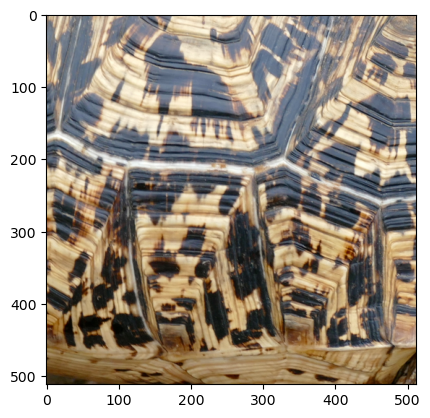

In [6]:
# load a random div2k image
n = str(random.randint(1, 801)).zfill(4)
img = Image.open(f'div2k/DIV2k_train_HR/{n}.png')
transforms = torchvision.transforms.Compose([
    torchvision.transforms.CenterCrop(512),    
    torchvision.transforms.ToTensor()
])
img = transforms(img)
plt.imshow(img.permute(1, 2, 0))

In [7]:
y_coords = img.shape[1]
x_coords = img.shape[2]

x = torch.linspace(1, x_coords, x_coords).reshape(-1,1).to(device)
y = torch.linspace(1, y_coords, y_coords).reshape(-1,1).to(device)

In [8]:
# example: training a coordx network for image (2 branches) with a scale factor of 2 on the last hidden layer before the fusion
model = coordx_net(n_branches=2, out_channels=3, hidden_size=256, R=2, R_strat=1).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001) #lr=0.001 for image works if you do a low #epcohs, but n>2000 = unstable
accelerated_train(model=model, optimizer=optimizer, dims=[x,y], target=img, n_epochs=20000, print_step=500, n_samples=131072)

Iteration: 0 | Loss: 0.09161517769098282
Iteration: 500 | Loss: 0.029048219323158264
Iteration: 1000 | Loss: 0.012273047119379044
Iteration: 1500 | Loss: 0.007291419897228479
Iteration: 2000 | Loss: 0.005045389290899038
Iteration: 2500 | Loss: 0.003777618519961834
Iteration: 3000 | Loss: 0.0029663429595530033
Iteration: 3500 | Loss: 0.0024516305420547724
Iteration: 4000 | Loss: 0.002083973726257682
Iteration: 4500 | Loss: 0.0018224052619189024
Iteration: 5000 | Loss: 0.0016153639880940318
Iteration: 5500 | Loss: 0.0014190830988809466
Iteration: 6000 | Loss: 0.0012739220401272178
Iteration: 6500 | Loss: 0.0011511663906276226
Iteration: 7000 | Loss: 0.00106607296038419
Iteration: 7500 | Loss: 0.0009791066404432058
Iteration: 8000 | Loss: 0.0009225619724020362
Iteration: 8500 | Loss: 0.0008554821251891553
Iteration: 9000 | Loss: 0.0008020970853976905
Iteration: 9500 | Loss: 0.000766297394875437
Iteration: 10000 | Loss: 0.0007165326387621462
Iteration: 10500 | Loss: 0.0006887002382427454
I

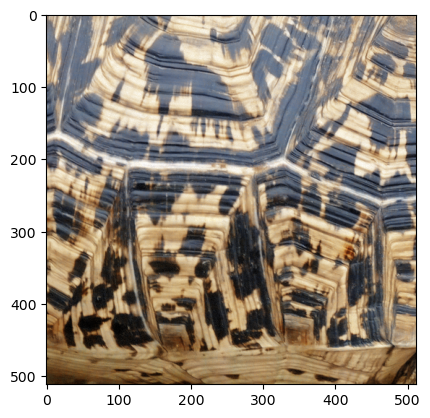

PSNR: 33.82606887817383


In [9]:
final = model([x,y])
plt.imshow(final.detach().cpu().permute(1, 2, 0).numpy())
plt.show()
print(f'PSNR: {psnr(img, final)}')

Regular train for reference

In [10]:
def train(model, optimizer:torch.optim, dims:list[torch.tensor], target:torch.tensor, n_epochs:int, print_step:int=1000):
    '''
    trains the coordx network
    @param model: the model to train
    @param optimizer: the optimizer to use
    @param dims: the input tensors containing the coordinates
    @param target: the target tensor    
    @param n_epochs: number of epochs to train for (20k for image, 100k for video)
    @param print_step: the step to print the loss
    '''
    loss_fn = torch.nn.MSELoss()
    for epoch in range(n_epochs+1):
        optimizer.zero_grad()
        out = model(dims)        
        loss = loss_fn(out, target)
        loss.backward()
        optimizer.step()
        if epoch % print_step == 0:
            print(f'Iteration: {epoch} | Loss: {loss.item()}')

In [11]:
# example: training a coordx network for image (2 branches) with a scale factor of 2 on the last hidden layer before the fusion
model_un = coordx_net(n_branches=2, out_channels=3, hidden_size=256, R=2, R_strat=1).to(device)
optimizer = torch.optim.Adam(model_un.parameters(), lr=0.0001) #lr=0.001 for image works if you do a low #epcohs, but n>2000 = unstable
x = x.to(device)
y = y.to(device)
train(model=model_un, optimizer=optimizer, dims=[x,y], target=img.to(device), n_epochs=20000, print_step=500)

Iteration: 0 | Loss: 0.09387992322444916
Iteration: 500 | Loss: 0.020872434601187706
Iteration: 1000 | Loss: 0.007132809609174728
Iteration: 1500 | Loss: 0.004132205154746771
Iteration: 2000 | Loss: 0.002903569955378771
Iteration: 2500 | Loss: 0.0022111190482974052
Iteration: 3000 | Loss: 0.0017608243506401777
Iteration: 3500 | Loss: 0.001441383152268827
Iteration: 4000 | Loss: 0.001207329798489809
Iteration: 4500 | Loss: 0.0010282570729032159
Iteration: 5000 | Loss: 0.0008883420377969742
Iteration: 5500 | Loss: 0.0007748273201286793
Iteration: 6000 | Loss: 0.0006820462876930833
Iteration: 6500 | Loss: 0.0006049106013961136
Iteration: 7000 | Loss: 0.0005392352468334138
Iteration: 7500 | Loss: 0.0004852455749642104
Iteration: 8000 | Loss: 0.00044308003270998597
Iteration: 8500 | Loss: 0.00040913940756581724
Iteration: 9000 | Loss: 0.00037820482975803316
Iteration: 9500 | Loss: 0.00035431457217782736
Iteration: 10000 | Loss: 0.00033555220579728484
Iteration: 10500 | Loss: 0.0003202308434

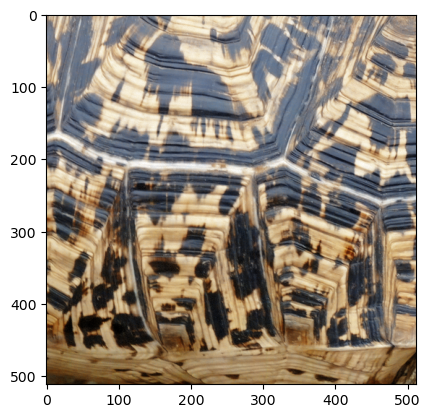

PSNR: 36.67573547363281


In [13]:
final = model_un([x,y])
plt.imshow(final.detach().cpu().permute(1, 2, 0).numpy())
plt.show()
print(f'PSNR: {psnr(img, final.cpu())}')